In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import missingno as msno
import openpyxl
import warnings
warnings.filterwarnings('ignore')


In [8]:
data = pd.read_pickle('df_accepted.plk')
data.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,68407277,NaN,3600.0,3600.0,3600.0,36 months,13.99,123.03,C,C4,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
1,68355089,NaN,24700.0,24700.0,24700.0,36 months,11.99,820.28,C,C1,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
2,68341763,NaN,20000.0,20000.0,20000.0,60 months,10.78,432.66,B,B4,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
3,66310712,NaN,35000.0,35000.0,35000.0,60 months,14.85,829.90,C,C5,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
4,68476807,NaN,10400.0,10400.0,10400.0,60 months,22.45,289.91,F,F1,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2260701 entries, 0 to 2260700
Columns: 151 entries, id to settlement_term
dtypes: datetime64[ns](1), float64(113), object(37)
memory usage: 2.5+ GB


The dataframe currently consumes over 2.5 GB of memory. To improve processing efficiency, I will focus only on data entries from 2010 onwards. 

Additionally, some features have over 50% missing values, and without further information provided, I have decided to remove these features from our dataset to further reduce processing time. 


In [10]:
df = data.copy()
df['issue_d'] = pd.to_datetime(df['issue_d'])
df = df[df['issue_d'] >= '2010-01-01']

# Calculate the percentage of missing values for each column
missing_val_percentage  = df.isnull().sum() / len(df)

# Define the threshold for removal and identify columns to drop
removal_threshold = 0.5
cols_with_high_missing_values = missing_val_percentage [missing_val_percentage  > removal_threshold].index

# Drop columns with more than the threshold of missing values
df.drop(columns= cols_with_high_missing_values, inplace=True)

The excel file 'LCDataDictionary.xlsx' includes metadata for features in our dataframe. There are some redundant features in the file so we want to remove it. We also want to check whether there is any features that is not included in this file 

The Excel file 'LCDataDictionary.xlsx' includes metadata for the features in our dataframe. There are some redundant features in the file that we want to remove. Additionally, we want to check if there are any features in our dataframe that are not included in the file.

In [11]:
# Load and clean the metadata
metadata = pd.read_excel('LCDataDictionary.xlsx', engine='openpyxl')\
                                                          .dropna()

# Get the unique feature names from the metadata
meta_features = metadata['LoanStatNew'].unique()

# Find the columns in df that are not in the metadata features
columns_not_in_metadata = np.setdiff1d(df.columns, meta_features)
columns_not_in_metadata

array(['total_rev_hi_lim'], dtype=object)

After conducting research, I found the definition for total_rev_hi_lim. It stands for "Total revolving high credit/credit limit"

In [12]:
# add total_rev_hi_lim to metadata for later reference
metadata.loc[len(metadata)] = {'LoanStatNew': 'total_rev_hi_lim', 
                               'Description': 'Total revolving high credit/credit limit'}


In [13]:
# Set the index to the metadata for easier feature access
metadata.set_index('LoanStatNew', inplace=True)

Due to the large number of features in our dataframe, we are unable to use the matrix visualization from the missingno library to observe missing value patterns. Instead, I have to rely on using bar charts. Upon reviewing the bar chart, it becomes evident that certain features exhibit identical counts of missing values, prompting further investigation into the reasons behind these high numbers of missing values. 

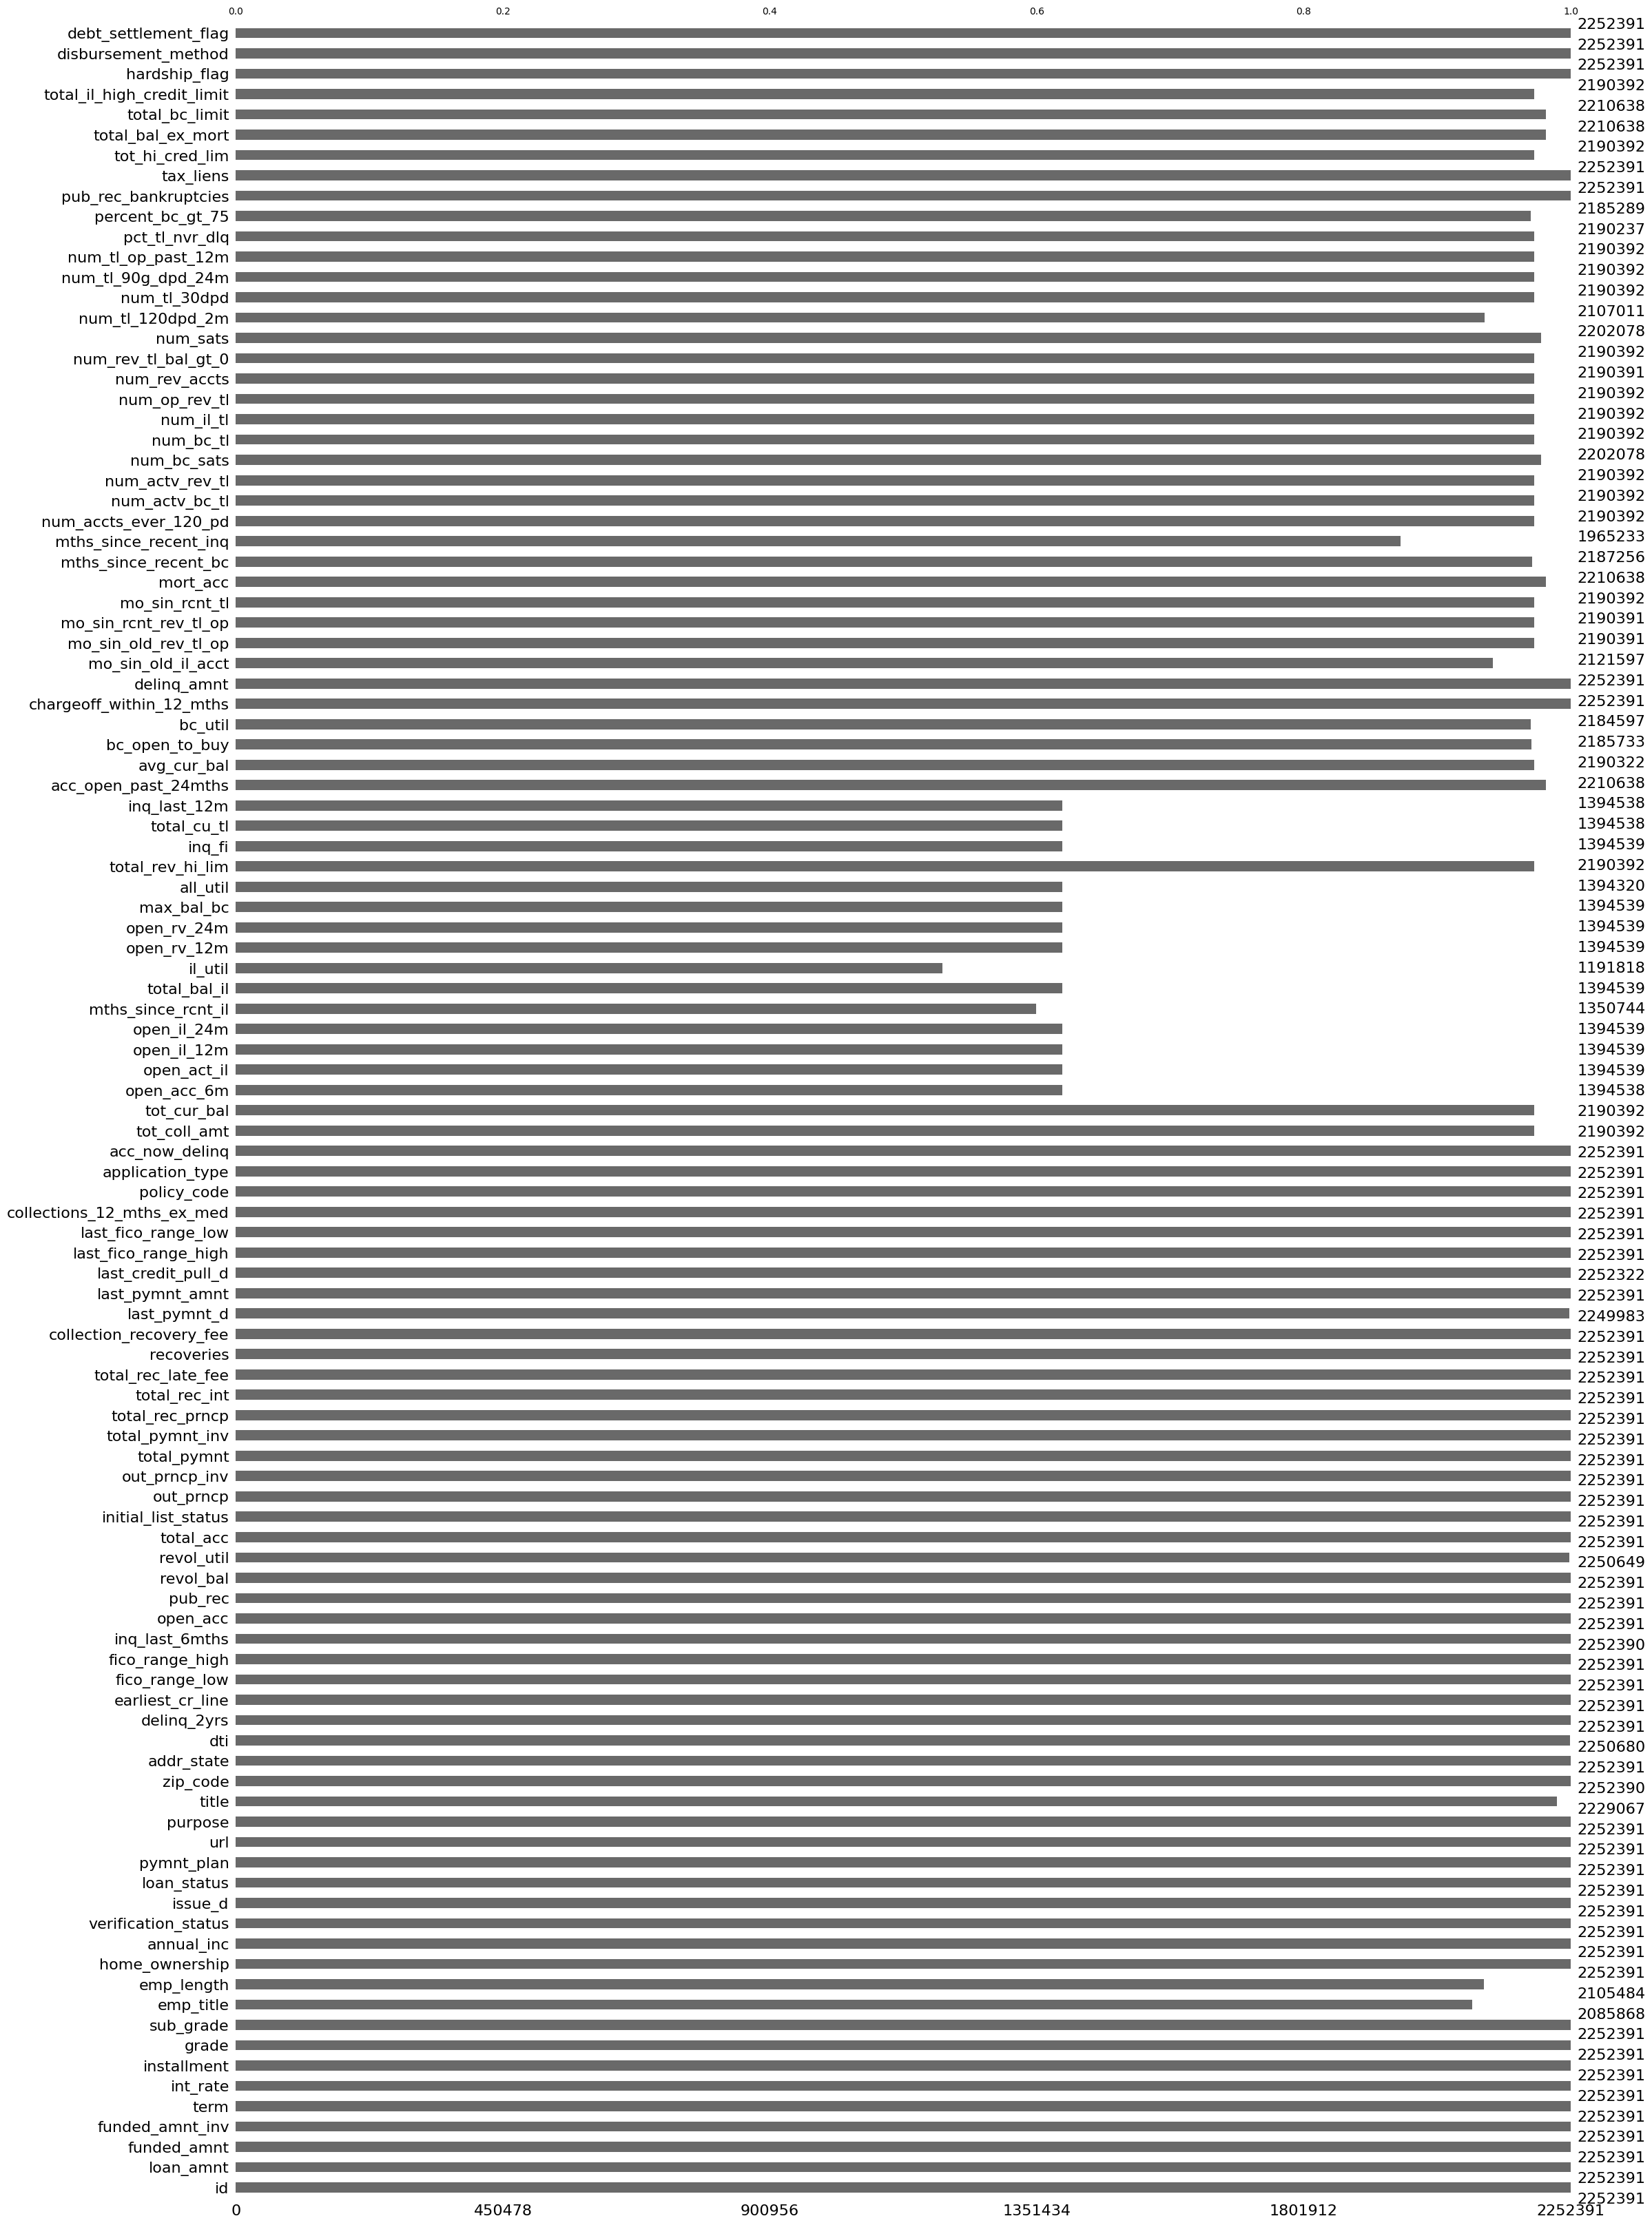

In [14]:
msno.bar(df)
plt.show()

In [15]:
display(df[~df['total_cu_tl'].isnull()]['issue_d'].dt.year.unique())
display(df[~df['inq_last_12m'].isnull()]['issue_d'].dt.year.unique())

array([2015, 2018, 2017, 2016], dtype=int32)

array([2015, 2018, 2017, 2016], dtype=int32)

Both 'total_cu_tl' and 'inq_last_12m' are examples of features with an identical number of missing values we see in the above bar graph. The available data spans only from 2015 to 2018, suggesting that information for these features is absent before 2015. As a result, I will filter our dataset to include only data from 2015 to 2018. This period provides a substantial amount of data for applying statistical and machine learning models effectively. However, during EDA (Exploratory Data Analysis) later on, I will utilized both the filtered dataset and full dataset flexibly to uncover important patterns that may be missed if we restrict analysis to data from 2015 onwards. 

In [16]:
display(df[~df['total_cu_tl'].isnull()]['issue_d'].min())
display(df[~df['total_cu_tl'].isnull()]['issue_d'].max())

Timestamp('2015-12-01 00:00:00')

Timestamp('2018-12-01 00:00:00')

In [17]:
# Filter the DataFrame for the years 2015 to 2018
df_2015_2018 = df[(df['issue_d']>= '2015-12-01') & (df['issue_d']<= '2018-12-01')]

<Axes: >

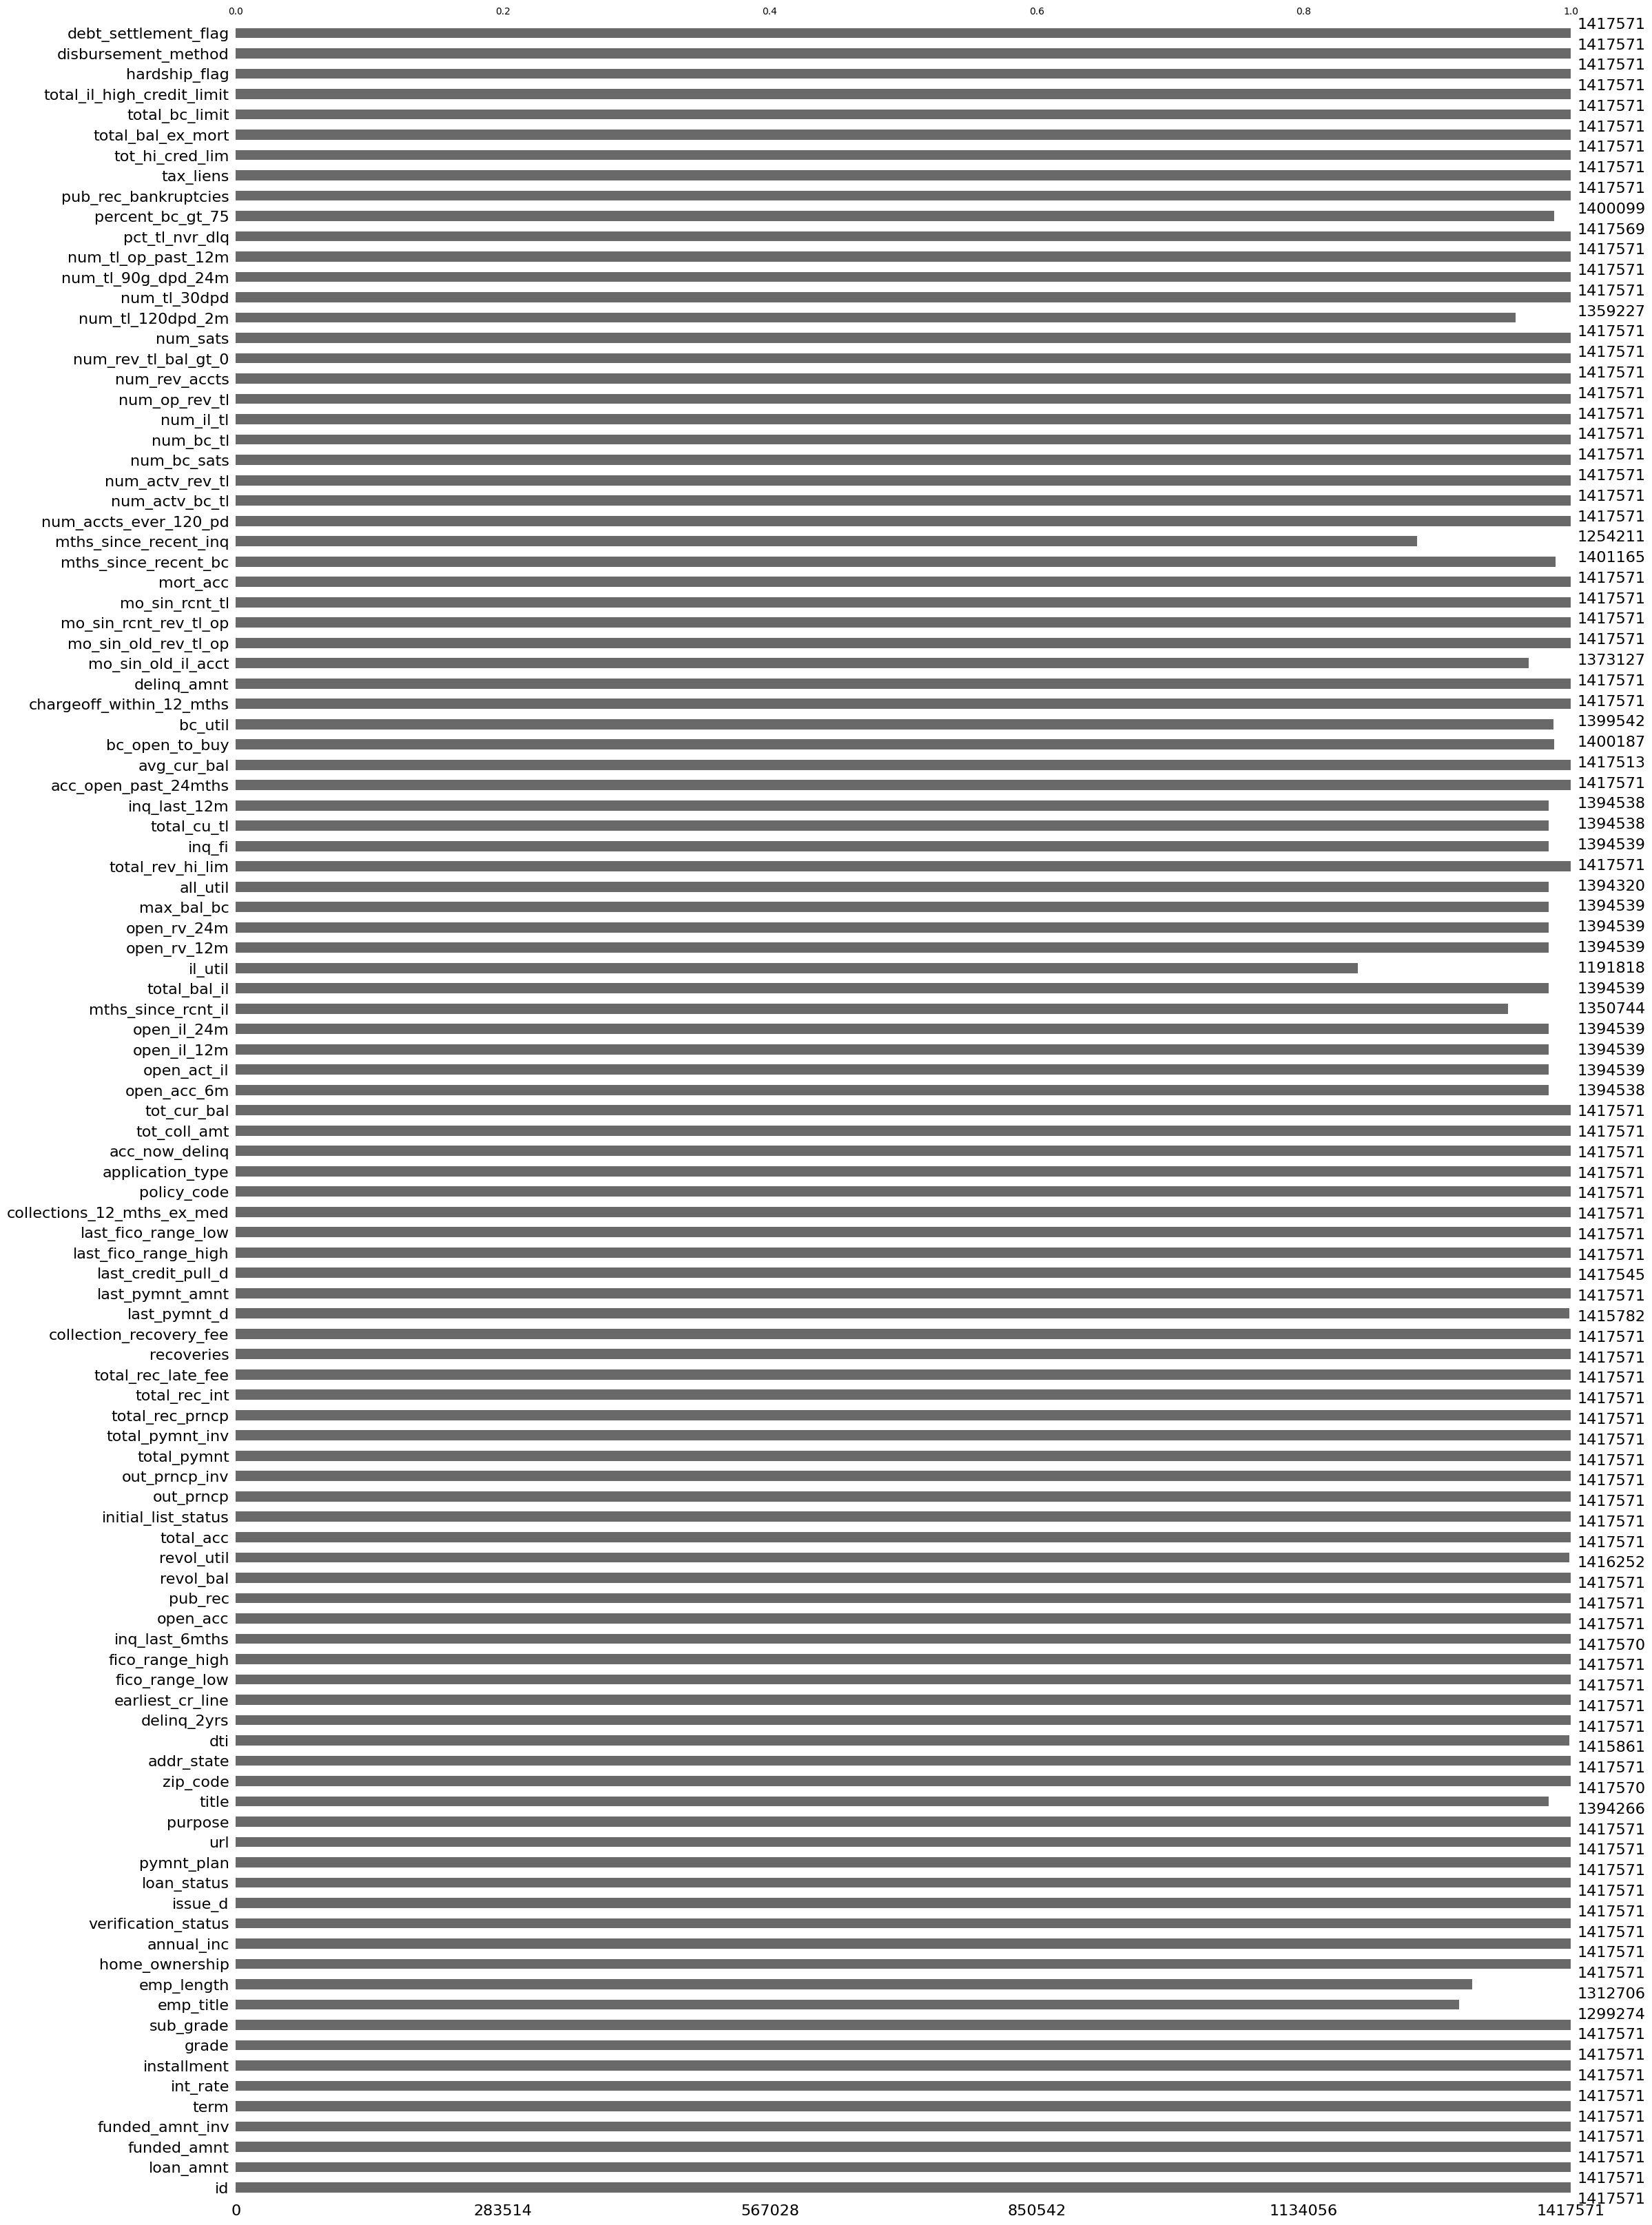

In [18]:
msno.bar(df_2015_2018)

In [19]:
# fill missing values data for all of remaining values.
# Since the continuous features for this data is highly skewed, 
# data entries with missing values will be filled with median. 
df[['emp_title','emp_length']].fillna('N/A', inplace = True)
df['title'].fillna('Other', inplace=True)

features_to_fill_with_median = ['revol_util', 'mths_since_rcnt_il', 'il_util',\
                                'bc_open_to_buy','bc_util','mo_sin_old_il_acct',\
                                'mths_since_recent_bc','mths_since_recent_bc','mths_since_recent_inq', \
                                'num_tl_120dpd_2m', 'percent_bc_gt_75']
for feature in features_to_fill_with_median:
    df[feature].fillna(df[feature].median(), inplace=True)
    
df.dropna(inplace=True)
df.drop(columns=['policy_code', 'id'], inplace=True)



In [20]:
# List of loan statuses considered as bad loans or good loans
bad_loans = ['Charged Off', 'Late (31-120 days)', 'Late (16-30 days)', 
             'Does not meet the credit policy. Status:Charged Off', 'Default']
good_loans = ['Fully Paid', 'Does not meet the credit policy. Status:Fully Paid']
# Update loan_status column for bad and good loans for dataset
df.loc[df['loan_status'].isin(bad_loans), 'loan_status'] = 'bad loans'
df.loc[df['loan_status'].isin(good_loans), 'loan_status'] = 'good loans'

In [21]:
df.loc[df['home_ownership'].isin(['ANY','NONE']),'home_ownership'] = 'OTHER'


In [22]:
metadata.at['home_ownership', 'Description']

'The home ownership status provided by the borrower during registration\xa0or obtained from the credit report.\xa0Our values are: RENT, OWN, MORTGAGE, OTHER'

In [23]:
df.to_csv('2015_2018_cleaned_dataset.csv')